# Experiment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.kernel_approximation import Nystroem #Nystroem
import torch

In [2]:
df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
#df=df.iloc[:1000]
train,test = train_test_split(df, train_size=0.7,random_state=1)
train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
train_x ##display the data

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
41023,47.58090,51.23695,42.14202,-1.55128,-32.38068,-0.22159,-17.24883,4.03834,0.63638,13.14812,...,45.50125,-207.98239,29.51603,43.95355,15.81620,31.53317,-155.29523,9.15115,125.73118,16.10946
137409,50.06922,57.83482,23.98710,-5.83465,-9.14362,-10.00140,1.43814,-1.81164,10.63548,3.59625,...,6.17209,0.05654,26.00716,11.99748,-5.37566,18.89858,11.98341,9.61346,3.80884,18.70771
277183,51.19684,88.28477,3.04973,-5.14134,-41.94906,-30.51041,-9.13985,-8.34211,6.25519,10.36509,...,27.37959,-113.36396,-57.30138,-19.32783,8.04192,-43.14488,-85.13709,5.71429,-11.58323,0.15450
162426,46.77540,-12.62961,-21.12765,-10.29240,7.60418,-10.70543,-3.13419,-5.18574,8.86097,-0.72982,...,14.71742,-43.25987,56.98176,47.79040,15.95429,1.47915,55.17214,9.48236,-41.12018,3.26026
257789,27.08303,-201.23907,-83.72476,-25.68031,16.19197,-37.29538,6.78612,29.69022,-42.99972,-5.71247,...,-136.37030,-389.04692,-535.14211,-432.02589,-66.28637,12.99753,-1572.91271,-36.66174,-667.67611,-135.98891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491263,51.49090,51.30144,20.58088,-9.14374,-9.95901,-23.54713,-6.05940,-0.04434,19.25317,2.63497,...,-13.74497,-68.64648,34.51042,49.81678,12.17775,57.64844,41.93876,-1.44311,2.25582,-2.28416
267336,47.06987,10.47262,23.81107,12.54394,3.47270,-3.62889,19.81398,8.51453,-5.86438,-0.92996,...,101.05205,-65.90430,-39.29799,-67.80821,3.10809,15.82685,52.84144,11.26181,-17.98757,-30.12669
470924,44.46250,37.11433,-27.18533,33.76675,7.31523,18.37826,25.49589,-5.25284,-18.41402,-14.04103,...,27.03303,-342.00207,-391.59900,157.17873,23.26258,55.27273,-15.68745,70.50363,-496.81627,-44.95163
491755,29.16706,-124.97979,-56.51979,-34.57494,26.46262,-13.06209,-24.11500,2.31353,1.62976,4.08517,...,76.61784,-600.41774,9.55287,-25.22799,20.13617,7.36672,89.80999,-9.09717,-20.17682,0.27964


## DNN

In [4]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

In [6]:
import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=50, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=50, shuffle=False)

class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(90, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 5)
        self.fc4 = nn.Linear(5, 1)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

t0 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.8) #optim.Adam(...)

dnn_trainloss=[]
dnn_testloss=[]
for epoch in tqdm(range(200)): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
            
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
        dnn_trainloss.append(float(train_loss))
        dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=90, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
)


  0%|          | 1/200 [00:12<40:14, 12.13s/it]

epoch 0
            Train set - loss: 184.9575958251953
            Test  set - loss: 59.21880340576172
            


  6%|▌         | 11/200 [01:55<34:32, 10.96s/it]

epoch 10
            Train set - loss: 60.61654281616211
            Test  set - loss: 58.843055725097656
            


 10%|█         | 21/200 [03:45<34:16, 11.49s/it]

epoch 20
            Train set - loss: 178.09547424316406
            Test  set - loss: 59.0162467956543
            


 16%|█▌        | 31/200 [05:44<35:44, 12.69s/it]

epoch 30
            Train set - loss: 132.7847137451172
            Test  set - loss: 58.76819610595703
            


 20%|██        | 41/200 [07:41<32:14, 12.17s/it]

epoch 40
            Train set - loss: 101.0751724243164
            Test  set - loss: 58.774375915527344
            


 26%|██▌       | 51/200 [09:41<30:34, 12.32s/it]

epoch 50
            Train set - loss: 172.90834045410156
            Test  set - loss: 59.86004638671875
            


 30%|███       | 61/200 [11:39<28:29, 12.30s/it]

epoch 60
            Train set - loss: 107.22042846679688
            Test  set - loss: 58.75000762939453
            


 36%|███▌      | 71/200 [13:37<26:19, 12.24s/it]

epoch 70
            Train set - loss: 117.70008850097656
            Test  set - loss: 58.939170837402344
            


 40%|████      | 81/200 [15:34<24:07, 12.17s/it]

epoch 80
            Train set - loss: 200.94415283203125
            Test  set - loss: 58.87731170654297
            


 46%|████▌     | 91/200 [17:33<22:48, 12.56s/it]

epoch 90
            Train set - loss: 145.0782928466797
            Test  set - loss: 58.766807556152344
            


 50%|█████     | 101/200 [19:29<20:01, 12.13s/it]

epoch 100
            Train set - loss: 122.72132110595703
            Test  set - loss: 59.07706832885742
            


 56%|█████▌    | 111/200 [21:27<18:16, 12.32s/it]

epoch 110
            Train set - loss: 259.5238342285156
            Test  set - loss: 58.75
            


 60%|██████    | 121/200 [23:28<17:04, 12.97s/it]

epoch 120
            Train set - loss: 165.35498046875
            Test  set - loss: 58.75901794433594
            


 66%|██████▌   | 131/200 [25:19<14:20, 12.47s/it]

epoch 130
            Train set - loss: 93.59932708740234
            Test  set - loss: 58.889076232910156
            


 70%|███████   | 141/200 [27:12<11:25, 11.61s/it]

epoch 140
            Train set - loss: 90.42495727539062
            Test  set - loss: 58.803680419921875
            


 76%|███████▌  | 151/200 [29:02<09:20, 11.43s/it]

epoch 150
            Train set - loss: 103.06829071044922
            Test  set - loss: 58.7652587890625
            


 80%|████████  | 161/200 [30:52<07:25, 11.43s/it]

epoch 160
            Train set - loss: 82.6591796875
            Test  set - loss: 58.86309814453125
            


 86%|████████▌ | 171/200 [32:43<05:32, 11.47s/it]

epoch 170
            Train set - loss: 92.19304656982422
            Test  set - loss: 58.876014709472656
            


 90%|█████████ | 181/200 [34:33<03:38, 11.48s/it]

epoch 180
            Train set - loss: 95.63478088378906
            Test  set - loss: 58.807769775390625
            


 96%|█████████▌| 191/200 [36:23<01:42, 11.44s/it]

epoch 190
            Train set - loss: 153.44143676757812
            Test  set - loss: 58.86073303222656
            


100%|██████████| 200/200 [38:00<00:00, 11.40s/it]

DNN complexity and model fitted in 2280.274 s


## One kernel machine for different number of Random Feature

random feature class

In [4]:
def ft_gaussian(x):
    """FT of gaussian, normalized so that max_x pdf(x) = 1"""
    return np.exp(-0.5 * (np.linalg.norm(x) ** 2))

def ft_laplacian(x):
    """FT of laplacian, normalized so that max_x pdf(x) = 1"""
    return np.prod(np.asarray([1/(1 + x_i ** 2) for x_i in x]))

def ft_cauchy(x):
    """FT of cauchy, normalized so that max_x pdf(x) = 1"""
    return np.exp(-1 * sum(np.abs(x)))

KERNELS = {
    'G': ft_gaussian,
    'L': ft_laplacian,
    'C': ft_cauchy
}

def sample_1d(pdf, gamma, interval):
    """Monte-Carlo rejection sampling"""
    while True:
        w = np.random.rand(1) * (interval[1] - interval[0]) + interval[0] #U(interval)
        y = np.random.rand(1) #U[0,1]

        if y <= pdf(w/gamma):  #p_new(x) ~ p(x/gamma) -- transform the standard pdf
            return w

def sample(pdf, gamma, d):
    """Monte Carlo Rejection Sampling"""
    return [sample_1d(pdf, gamma, [-10*gamma, 10*gamma]) for _ in range(d)]


class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : np.array
        shape (D,d)
    b : np.array
        shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    References
    ----------
    ..  [1] A. Rahimi, B. Recht, "Random Features for Large-Scale Kernel
        Machines"
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = np.random.uniform(0, 2 * np.pi, self.D)
        
        self.W = np.reshape(
            np.array([
                sample(KERNELS[self.kernel], self.gamma, self.d)
                for _ in range(self.D)], dtype=np.float32),
            (self.D, self.d))

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : np.array (shape=(n,d))
            Array to transform; must be single dimension vector
        Returns
        -------
        x : np.array (shape=(n,D))
            Feature space transformation of x
        """
        
        result=np.array([
            np.sqrt(2 / self.D) * np.cos(np.dot(self.W, x.iloc[i]) + self.b) for i in range(len(x))]
            )
            
        return result

    def __str__(self):
        """Get string representation
        Shown as "<d>-><D> Random Fourier Feature"
        """
        return (
            "{d}->{D} Random Fourier Feature"
            .format(d=self.d, D=self.D))

In [14]:
total_x=pd.concat([train_x,test_x])
model =LinearRegression()
Layer=1
m0set=np.linspace(11,50,40)
m0set=m0set.astype(int)
gaset=np.logspace(-7,-1,4)
n0=8

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in tqdm(m0set):  
        for i in range(n0):
            rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
            feature=rff.transform(total_x)
            train_xtransformed=feature[:len(train_x)]
            test_xtransformed=feature[len(train_x):]
            model.fit(train_xtransformed, train_y)
            if i==0:
                y_pretest=model.predict(test_xtransformed)
                y_pretrain=model.predict(train_xtransformed)
            else:
                y_pretest=y_pretest+model.predict(test_xtransformed)
                y_pretrain=y_pretrain+model.predict(train_xtransformed) 
        
        y_pretest=y_pretest/n0
        y_pretrain=y_pretrain/n0
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature-GAUSSIAN")
plt.legend(["trainmse:gamma=10e-7","testmse:gamma=10e-7","trainmse:gamma=10e-5","testmse:gamma=10e-5","trainmse:gamma=10e-3","testmse:gamma=10e-3","trainmse:gamma=10e-1","testmse:gamma=10e-1"])
plt.show()


 75%|███████▌  | 30/40 [2:00:32<40:10, 241.10s/it]


KeyboardInterrupt: 

## Network learning

In [18]:
import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=50, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=50, shuffle=False)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(100, 60)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(20, 5)
        self.fc4 = nn.Linear(10, 1)
 
    def forward(self, x):
        rff=RandomFourierFeature(90,100,kernel='G',gamma=10**(-1))
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        rff=RandomFourierFeature(60,50,kernel='G',gamma=10**(-2))
        y=self.fc1(x).detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        rff=RandomFourierFeature(30,20,kernel='G',gamma=10**(-3))
        y=self.fc2(x).detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        rff=RandomFourierFeature(5,10,kernel='G',gamma=10**(-4))
        y=self.fc3(x).detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        return self.fc4(x)

t0 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.8) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]

for epoch in tqdm(range(200)): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
        kernelnn_trainloss.append(float(train_loss))
        kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=100, out_features=60, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


  0%|          | 0/200 [01:01<?, ?it/s]


KeyboardInterrupt: 

## Residual learning

100%|██████████| 6/6 [58:32<00:00, 585.42s/it]


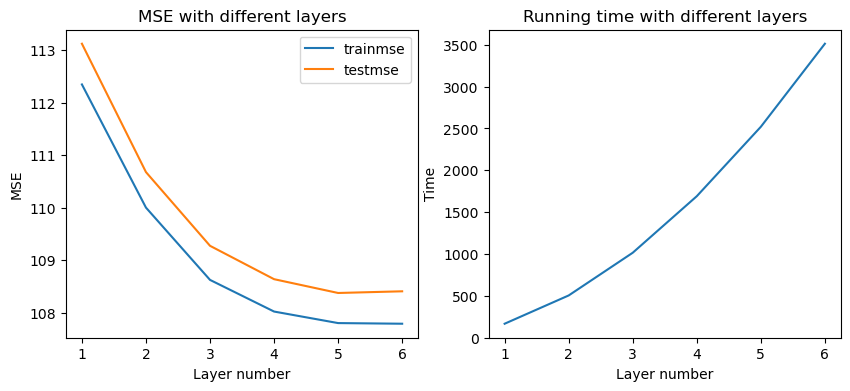

In [6]:
model = LinearRegression()
layerset=np.linspace(1,6,6)
layerset=layerset.astype(int)
m0=20
gamma0=0.0001
n0=8
trainmse=[]
testmse=[]
t=[]
t0 = time.time()

for layer in tqdm(layerset):
    length=int(len(train_x)/layer)
    for l in range(layer):  #ml points, nl sampling
        if l==0:
            for i in range(n0):
                rff=RandomFourierFeature(90,m0,kernel='G',gamma=gamma0/10**l)
                total_x=pd.concat([train_x,test_x])
                feature=rff.transform(total_x)
                train_xtransformed=feature[:len(train_x)]
                test_xtransformed=feature[len(train_x):]
                train_xltransformed=feature[l*length:(l+1)*length]
                
                model.fit(train_xltransformed, train_y[l*length:(l+1)*length])
                if i==0:
                    yl_kr=model.predict(test_xtransformed)
                    yl_kltrain=model.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+model.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
            
            y_kr=yl_kr/n0
            y_krtrain=yl_kltrain/n0
            
        else:
            for i in range(n0):
                rff=RandomFourierFeature(90,m0,kernel='G',gamma=gamma0/10**l)
                total_x=pd.concat([train_x,test_x])
                feature=rff.transform(total_x)
                train_xtransformed=feature[:len(train_x)]
                test_xtransformed=feature[len(train_x):]
                train_xltransformed=feature[l*length:(l+1)*length]
                
                model.fit(train_xltransformed, train_y[l*length:(l+1)*length]-y_krtrain[l*length:(l+1)*length]) ##fit residual
                if i==0:
                    yl_kr=model.predict(test_xtransformed)
                    yl_kltrain=model.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+model.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
                
            y_kr=y_kr+yl_kr/n0
            y_krtrain=y_krtrain+yl_kltrain/n0    
    
    
    kernel_fit = time.time() - t0
    
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,y_krtrain))
    testmse.append(mean_squared_error(test_y,y_kr))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(layerset,trainmse)
ax[0].plot(layerset,testmse)
ax[0].legend(["trainmse","testmse"])
ax[0].set_xlabel("Layer number")
ax[0].set_ylabel("MSE")
ax[0].set_title("MSE with different layers")

ax[1].plot(layerset,t)
ax[1].set_xlabel("Layer number")
ax[1].set_ylabel("Time")
ax[1].set_title("Running time with different layers")
plt.show()

random data splitting

In [ ]:
model = LinearRegression()
m0=20
gamma0=0.000001
n0=8
t0 = time.time()
layer=5
length=int(len(train_x)/layer)


for l in tqdm(range(layer)):  #ml points, nl sampling
    if l==0:
        for i in range(n0):
            rff=RandomFourierFeature(90,m0,kernel='G',gamma=gamma0/10**l)
            total_x=pd.concat([train_x,test_x])
            feature=rff.transform(total_x)
            train_xtransformed=feature[:len(train_x)] 
            test_xtransformed=feature[len(train_x):]
            
            #data splitting
            a=pd.DataFrame(train_y).values
            b=pd.DataFrame(train_xtransformed).values
            a=pd.DataFrame(a)
            a.columns=['y']
            b=pd.DataFrame(b)
            concatt=pd.concat([a,b],axis=1)
            train_xltransformed,rest = train_test_split(concatt, train_size=0.3)
            train_yltransformed=train_xltransformed['y']
            del train_xltransformed['y']
                
            model.fit(train_xltransformed, train_yltransformed)
            if i==0:
                yl_kr=model.predict(test_xtransformed)
                yl_kltrain=model.predict(train_xtransformed)
            else:
                yl_kr=yl_kr+model.predict(test_xtransformed)
                yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
            
        y_kr=yl_kr/n0
        y_krtrain=yl_kltrain/n0
            
    else:
        for i in range(n0):
            rff=RandomFourierFeature(90,m0,kernel='C',gamma=gamma0/10**l)
            total_x=pd.concat([train_x,test_x])
            feature=rff.transform(total_x)
            train_xtransformed=feature[:len(train_x)] 
            test_xtransformed=feature[len(train_x):]
            
            #data splitting
            a=pd.DataFrame(train_y).values
            ap=pd.DataFrame(y_krtrain).values
            b=pd.DataFrame(train_xtransformed).values
            a=pd.DataFrame(a)
            a.columns=['y']
            ap=pd.DataFrame(ap)
            ap.columns=['yp']
            b=pd.DataFrame(b)
            concatt=pd.concat([a,ap,b],axis=1)
            train_xltransformed,rest = train_test_split(concatt, train_size=0.4)
            train_yltransformed=train_xltransformed['y']
            yl_krtrain=train_xltransformed['yp']
            del train_xltransformed['y']
            del train_xltransformed['yp']
                
            model.fit(train_xltransformed, train_yltransformed-yl_krtrain) ##fit residual
            if i==0:
                yl_kr=model.predict(test_xtransformed)
                yl_kltrain=model.predict(train_xtransformed)
            else:
                yl_kr=yl_kr+model.predict(test_xtransformed)
                yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
                
        y_kr=y_kr+yl_kr/n0
        y_krtrain=y_krtrain+yl_kltrain/n0  
        
kernel_fit = time.time() - t0 

print("train_mse",mean_squared_error(train_y,y_krtrain))
print("test_mse",mean_squared_error(test_y,y_kr))
print("Res KernelNet complexity and model fitted in %.3f s" % kernel_fit)

100%|██████████| 4/4 [11:04<00:00, 166.15s/it]

train_mse 111.17638048248446
test_mse 111.91357794115811
Res KernelNet complexity and model fitted in 664.615 s
